In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.init as weight_init
import matplotlib.pyplot as plt
import pdb


#parameters
batch_size = 128

preprocess = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

#Loading the train set file
dataset = datasets.MNIST(root='./data',
                            transform=preprocess,  
                            download=True)

loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [9]:
class AE(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.features = features
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,self.features),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.features, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Tanh()
        )
    
    def forward(self,x):
        h = self.encoder(x)
        xr = self.decoder(h)
        return xr,h


In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('Using CUDA ', use_cuda)


#Mean square loss function
criterion = nn.MSELoss()

#Parameters
learning_rate = 1e-2
weight_decay = 1e-5

#Optimizer and Scheduler
def getOptimizer(net):
    optimizerAdam = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    optimizerSGD = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    optimizerSGDM = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    optimizerRMSprop = torch.optim.RMSprop(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

    optimizers = [optimizerAdam,optimizerRMSprop,optimizerSGD,optimizerSGDM]
    return optimizers
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

Using CUDA  True


In [11]:


#Training
def train(net,optimizer,num_epochs = 10):
    epochLoss = []
    for epoch in range(num_epochs):
        total_loss, cntr = 0, 0

        for i,(images,_) in enumerate(loader):

            images = images.view(-1, 28*28)
            images = images.to(device)

            # Initialize gradients to 0
            optimizer.zero_grad()

            # Forward pass (this calls the "forward" function within Net)
            outputs, _ = net(images)

            # Find the loss
            loss = criterion(outputs, images)

            # Find the gradients of all weights using the loss
            loss.backward()

            # Update the weights using the optimizer and scheduler
            optimizer.step()

            total_loss += loss.item()
            cntr += 1

    #     scheduler.step(total_loss/cntr)
        print ('Epoch [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, total_loss/cntr))
        epochLoss.append(total_loss/cntr)
    return epochLoss

Epoch [1/10], Loss: 0.6174
Epoch [2/10], Loss: 0.5854
Epoch [3/10], Loss: 0.5780
Epoch [4/10], Loss: 0.5757
Epoch [5/10], Loss: 0.5787
Epoch [6/10], Loss: 0.5871
Epoch [7/10], Loss: 0.5776
Epoch [8/10], Loss: 0.5725
Epoch [9/10], Loss: 0.5728
Epoch [10/10], Loss: 0.5713
Epoch [1/10], Loss: 0.5813
Epoch [2/10], Loss: 0.5381
Epoch [3/10], Loss: 0.5307
Epoch [4/10], Loss: 0.5334


KeyboardInterrupt: 

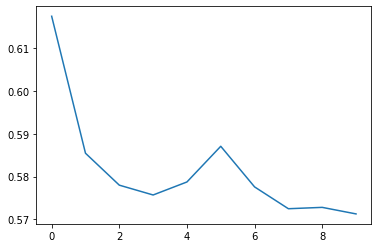

In [15]:
for j in range(4):
    for i in range(10):
        net = AE(i+1)
        net.to(device)
        optimizers = getOptimizer(net)    
        plt.plot(train(net,optimizers[j]))
    plt.title('%d'%(i+1))
    plt.legend([k for k in range(1,11)])
    plt.show()